# Predicting Hospital Discharge Outcomes

### **Introduction: Thought Process Behind This Project**  

In this project, we aimed to develop a **predictive model for hospital discharge outcomes**, balancing both **clinical accuracy and financial impact**. The motivation stemmed from the need to **improve patient management at UVA Hospital** while minimizing costly misclassifications. Given that **false negatives (patients predicted as safe for discharge but actually at risk) cost 347** per case and **false positives (patients unnecessarily retained) cost 72**, our approach was designed to prioritize **reducing false negatives** while maintaining a reasonable false positive rate.  

To achieve this, we structured the project into several key phases:  

1. **Data Preprocessing & Feature Engineering** – Handling categorical and numerical variables, imputing missing values, and encoding rare categories to ensure a robust dataset.  
2. **Model Selection & Hyperparameter Optimization** – Leveraging **XGBoost** due to its efficiency with structured data and tuning hyperparameters using **Bayesian optimization (Hyperopt)** to maximize predictive power.  
3. **Cost-Sensitive Decision Making** – Instead of relying on the default classification threshold (0.5), we adjusted the threshold based on probability scores to **minimize the overall financial cost of misclassification**.  
4. **Evaluation & Business Impact Analysis** – Assessing performance using **AUC-ROC, precision-recall trade-offs, and a confusion matrix**, ensuring the model aligns with real-world hospital operations.  

By incorporating **data-driven decision-making and cost-aware optimization**, this project bridges **machine learning with practical hospital resource management**, ultimately improving **patient care and financial efficiency**. 

## 1. Import packages

First, we will import our normal selection of packages. However, this time, we will be importing the classification version of the models we've been using. These will have different names, but generally, the parameters will be identical or nearly so.

In [1]:
import numpy as np # Library for math operations
import pandas as pd # Library for data handling
import sklearn # The machine learning library we will be using in this entire course
from sklearn import tree # Tree function is used for visualizing decision tree
from sklearn.metrics import * 
# Importing function that can be used to calculate different metrics
from sklearn.tree import DecisionTreeClassifier # Importing Decision Tree Classifier 
from sklearn.ensemble import RandomForestClassifier  # Importing Random Forest Classifier 
from sklearn.model_selection import train_test_split # Importing function that can split a dataset into training and testing set
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler # Importing function for scaling the data
from sklearn.model_selection import GridSearchCV # Importing GridSearchCV
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier # Importing the XGBoost Classifier 
import matplotlib.pyplot as plt # Importing the package for plotting
plt.style.use('fivethirtyeight') # Use the styling from FiveThirtyEight Website
import seaborn as sns # Importing another package for plotting

from custom_functions import plot_conf_mat, plot_roc_curve, plot_feature_importance, calculateMetricsAndPrint

## 2. Load the Data

In [2]:
trainInput = pd.read_csv("DischargeTrain.csv")
testInput = pd.read_csv("DischargeTest.csv")

In [3]:
trainInput.head(2)

,Unique_Patient_Encounter_ID,Discharge_Type,Unique_Patient_ID,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type,Age,ReadmissionCount,Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx),...,Subacute/SNF vs HHPT pending progress+First*(PTValue),Script given to CM+First*(PTValue),Long Term Acute Care Hospital+First*(PTValue),Home with nearly 24/7+First*(PTValue),Home with initial 24/7+First*(PTValue),Outpatient Cardiac rehab+First*(PTValue),Outpatient Pulmonary rehab+First*(PTValue),Hospice+First*(PTValue),AMPAC_Raw_Score,AMPAC_Scaled_Score
0,33434057,Home Health Agency,298873,Female,Single,Medicare Replacement,NaN,54,1,0,...,0,0,0,0,0,0,0,0,0,0
1,38150727,Infusion / Home,165661,Male,Divorced,Do not use,NaN,58,1,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
testInput.head(2)

,Unique_Patient_Encounter_ID,Discharge_Type,Unique_Patient_ID,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type,Age,ReadmissionCount,Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx),...,Subacute/SNF vs HHPT pending progress+First*(PTValue),Script given to CM+First*(PTValue),Long Term Acute Care Hospital+First*(PTValue),Home with nearly 24/7+First*(PTValue),Home with initial 24/7+First*(PTValue),Outpatient Cardiac rehab+First*(PTValue),Outpatient Pulmonary rehab+First*(PTValue),Hospice+First*(PTValue),AMPAC_Raw_Score,AMPAC_Scaled_Score
0,37607139,Skilled Nursing Facility (SNF),227723,Female,Divorced,Medicare,NaN,89,0,10,...,0,0,0,0,0,0,0,0,18,0
1,34657024,Skilled Nursing Facility (SNF),188569,Female,Widowed,Medicare,NaN,80,0,0,...,0,0,0,0,0,0,0,0,16,0


Let's take a look at the shape of these dataframes.

In [5]:
trainInput.shape

(17435, 833)

In [6]:
testInput.shape

(5812, 833)

Before moving forward, we need to create our target variable. Our target variable should be equal to 1 if the discharge needs paperwork, and 0 otherwise. Let's take a look at the discharge types and then determine which ones require paperwork:

In [7]:
trainInput['Discharge_Type'].value_counts()

Discharge_Type
Home Health Agency                                        5696
HOME                                                      4790
Skilled Nursing Facility (SNF)                            3025
Acute Rehabilitation Facility (hospital or unit) (IRF)    1150
EXPIRED                                                    972
Infusion / Home                                            712
Long Term Care Hospital (LTCH)                             395
Hospice / Home                                             367
DIS TO LAW ENFORCE                                         166
AGAINST MED ADVICE                                         162
Name: count, dtype: int64

The types of discharge that require additional paperwork are `Skilled Nursing Facility (SNF)`, `Acute Rehabilitation Facility (hospital or unit) (IRF)`, and `Long Term Care Hospital (LTCH)`, so we will create a new variable which is `1` if any of those three are the discharge type or `0` if not.

In [8]:
trainInput['Requires_Paperwork'] = \
np.where(trainInput['Discharge_Type'].isin(['Skilled Nursing Facility (SNF)',
                                           'Acute Rehabilitation Facility (hospital or unit) (IRF)',
                                           'Long Term Care Hospital (LTCH)']),1,0)

trainInput['Requires_Paperwork'].value_counts()

Requires_Paperwork
0    12865
1     4570
Name: count, dtype: int64

In [9]:
testInput['Requires_Paperwork'] = \
np.where(testInput['Discharge_Type'].isin(['Skilled Nursing Facility (SNF)',
                                           'Acute Rehabilitation Facility (hospital or unit) (IRF)',
                                           'Long Term Care Hospital (LTCH)']),1,0)

testInput['Requires_Paperwork'].value_counts()

Requires_Paperwork
0    4267
1    1545
Name: count, dtype: int64

Now, we can go ahead and separate our x and y. Given that `Requires_Paperwork` is still fully correlated with our new y (`Requires_Paperwork`), we have to drop that as well. In addition, `Unique_Patient_Encounter_ID` and `Unique_Patient_ID` are unique identifiers and therefore there is no value in using them as predictors. So, we drop these columns too. Also, because our y values (labels) are already 0s and 1s, we don't need LabelEncode them anymore:

In [10]:
trainData = trainInput.drop(columns = ['Unique_Patient_Encounter_ID',
                                       'Unique_Patient_ID',
                                       'Requires_Paperwork',
                                      'Discharge_Type'])
trainLabels = trainInput.Requires_Paperwork

testData = testInput.drop(columns = ['Unique_Patient_Encounter_ID',
                                     'Unique_Patient_ID',
                                     'Requires_Paperwork',
                                      'Discharge_Type'])
testLabels = testInput.Requires_Paperwork

## 3. Data Augmentations

In [11]:
!pip install feature-engine

  Using cached feature_engine-1.8.3-py2.py3-none-any.whl.metadata (9.9 kB)
  Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
Using cached feature_engine-1.8.3-py2.py3-none-any.whl (378 kB)
Using cached pandas-2.2.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.1 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 2.1.4
    Uninstalling pandas-2.1.4:
      Successfully uninstalled pandas-2.1.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pycaret 3.3.1 requires matplotlib<3.8.0, but you have matplotlib 3.9.1 which is incompatible.
pycaret 3.3.1 requires pandas<2.2.0, but you have pandas 2.2.3 which is incompatible.
sktime 0.26.0 requires pandas<2.2.0,>=1.1, but you have pandas 2.2.3 which is incompatible.


### 3.1. Treat Missing Values

Before starting the data augmentations, we need to check if we have any columns with missing values. If so, we need to process them first:

In [13]:
trainData.columns[trainData.isnull().any()].tolist()

['Previous_Discharge_Type']

In [14]:
testData.columns[testData.isnull().any()].tolist()

['Previous_Discharge_Type']

In [15]:
trainData.astype(str)

,Sex,Marital_Status,Payment_Class,Previous_Discharge_Type,Age,ReadmissionCount,Diseases of the circulatory system-Cerebrovascular disease+Count*(sk_dim_dx),Diseases of the circulatory system-Diseases of arteries; arterioles; and capillaries+Count*(sk_dim_dx),Diseases of the musculoskeletal system and connective tissue-Acquired deformities+Count*(sk_dim_dx),Diseases of the musculoskeletal system and connective tissue-Non-traumatic joint disorders+Count*(sk_dim_dx),...,Subacute/SNF vs HHPT pending progress+First*(PTValue),Script given to CM+First*(PTValue),Long Term Acute Care Hospital+First*(PTValue),Home with nearly 24/7+First*(PTValue),Home with initial 24/7+First*(PTValue),Outpatient Cardiac rehab+First*(PTValue),Outpatient Pulmonary rehab+First*(PTValue),Hospice+First*(PTValue),AMPAC_Raw_Score,AMPAC_Scaled_Score
0,Female,Single,Medicare Replacement,nan,54,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
1,Male,Divorced,Do not use,nan,58,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Male,Married,Medicare Managed Care,nan,73,0,0,0,2,0,...,0,0,0,0,0,0,0,0,13,0
3,Female,Married,Medicare Replacement,nan,61,0,0,0,0,20,...,0,0,0,0,0,0,0,0,0,0
4,Female,Married,Medicare,Skilled Nursing Facility (SNF),72,0,13,7,2,10,...,0,0,0,0,0,0,0,0,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17430,Male,Married,Grant,nan,84,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17431,Female,Widowed,Medicare,nan,87,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,0
17432,Female,Married,Medicare,nan,80,0,8,2,0,0,...,0,0,0,0,0,0,0,0,0,0
17433,Female,Married,Blue Shield,nan,62,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


This column captures the previous discharge type if known. Given that many patients may not have a previous discharge status, or their previous discharge could be related to years ago, we just replace the missing values under this column with "Unkown":

In [1]:
# Import the CategoricalImputer class from feature_engine
from feature_engine.imputation import CategoricalImputer  

# Initialize the CategoricalImputer
imp = CategoricalImputer(
    imputation_method='missing',  # Specifies that missing values should be replaced with a placeholder
    fill_value="Unknown"  # The placeholder value to use for missing categorical values
)

# Apply the imputer to training and test data
trainData = imp.fit_transform(trainData)  # Fit the imputer on trainData and transform it
testData = imp.transform(testData)  # Transform testData using the same imputation learned from trainData

ModuleNotFoundError: No module named 'feature_engine'

## 3.2 Build Pipeline for Preprocessing

### **Objective of the Following Code**  
This code **optimizes feature preprocessing and hyperparameters** for an **XGBoost classifier** to maximize the **AUC (Area Under the Curve) score**. It does so by systematically tuning both the preprocessing steps (such as handling rare labels, removing constant features, selecting uncorrelated features, and treating outliers) and the model hyperparameters using **Bayesian optimization with Hyperopt**.

### **Why Use a Pipeline for Preprocessing Optimization?**  
Using a **pipeline** ensures that all preprocessing steps are applied **consistently** and **efficiently** within the machine learning workflow. The main benefits of using a pipeline include:

1. **Automated Feature Processing**:  
   - Ensures that **feature transformations (categorical encoding, outlier treatment, feature selection, etc.)** are applied the same way during training and testing.

2. **Efficient Hyperparameter Tuning**:  
   - The pipeline integrates **feature engineering and modeling**, allowing the **entire process** to be optimized simultaneously.  
   - Instead of tuning preprocessing and modeling separately, the pipeline allows us to evaluate different configurations in one pass.

3. **Prevents Data Leakage**:  
   - Since preprocessing steps are included within cross-validation, transformations are **only learned from the training folds** and applied to validation data **properly**, preventing information leakage.

4. **Standardized Workflow**:  
   - Ensures **consistency** in feature transformations across different experiments and future datasets.

5. **Seamless Model Deployment**:  
   - Once the pipeline is optimized, it can be **directly used in production**, as it includes **both feature transformations and the final classifier**.

### **Conclusion**  
By using a **pipeline**, this approach ensures that the best possible feature preprocessing and model hyperparameters are **jointly optimized** for the most accurate and reliable predictions.

In [ ]:
%pip install hyperopt

In [17]:
# Import necessary libraries
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK  # Hyperparameter tuning
from sklearn.pipeline import Pipeline  # Pipeline for processing steps
from sklearn.compose import ColumnTransformer  # Applies different transformations to different data types
from sklearn.preprocessing import OrdinalEncoder  # Encodes categorical features for XGBoost
from sklearn.model_selection import cross_val_score  # Evaluates model performance with cross-validation
from feature_engine.encoding import RareLabelEncoder  # Groups rare categories into a single class
from feature_engine.selection import DropConstantFeatures, SmartCorrelatedSelection  # Feature selection tools
from feature_engine.outliers import Winsorizer  # Handles outliers by capping extreme values
from xgboost import XGBClassifier  # XGBoost model for classification
from sklearn.metrics import roc_auc_score  # Evaluation metric (AUC)

# Identify categorical columns in the dataset
categorical_features = trainData.select_dtypes(include=['object']).columns.tolist()

# Convert categorical columns to 'category' dtype for XGBoost compatibility
trainData[categorical_features] = trainData[categorical_features].astype("category")

# Define hyperparameter choices for categorical encoding and outlier handling
n_categories_choices = [1, 2, 3]  # Number of rare categories
winsorizer_tail_choices = ["left", "right", "both"]  # Outlier handling options

# Define the objective function for hyperparameter optimization
def objective(params):
    """
    Objective function to optimize Feature-engine preprocessing parameters
    and XGBoost hyperparameters, maximizing AUC score.
    """

    # Extract hyperparameters for feature preprocessing
    tol_rare = params['tol_rare']  # Tolerance for rare category grouping
    n_categories_rare = n_categories_choices[params['n_categories_rare']]  # Convert index-based choice
    tol_constant = params['tol_constant']  # Threshold for dropping constant features
    threshold_corr = params['threshold_corr']  # Correlation threshold for feature selection
    tail_winsorizer = winsorizer_tail_choices[params['tail_winsorizer']]  # Convert index-based choice

    # Define a preprocessing pipeline for categorical features
    categorical_transformer = Pipeline([
        ('rare_encoder', RareLabelEncoder(tol=tol_rare, n_categories=n_categories_rare)),  # Groups rare categories
        ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  # Encodes categorical variables
    ])

    # Define a full preprocessor for both categorical and numerical features
    preprocessor = ColumnTransformer([
        ('categorical', categorical_transformer, categorical_features),  # Apply categorical transformations
        ('numerical', 'passthrough', [col for col in trainData.columns if col not in categorical_features])  # Pass numerical features unchanged
    ])

    # Define the full machine learning pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),  # Apply data preprocessing
        ('drop_constant', DropConstantFeatures(tol=tol_constant)),  # Remove low-variance features
        ('correlation_selection', SmartCorrelatedSelection(threshold=threshold_corr)),  # Remove highly correlated features
        ('outlier_winsorizer', Winsorizer(tail=tail_winsorizer)),  # Handle outliers
        ('classifier', XGBClassifier(
            use_label_encoder=False,  # Disable older label encoding method
            eval_metric="auc",  # Use AUC as evaluation metric
            enable_categorical=True,  # Enable categorical feature handling in XGBoost
        ))
    ])

    # Evaluate the model using cross-validation and calculate mean AUC score
    auc = cross_val_score(pipeline, trainData, trainLabels, cv=5, scoring='roc_auc').mean()

    # Return the negative AUC (since Hyperopt minimizes loss)
    return {'loss': -auc, 'status': STATUS_OK}

# Define the hyperparameter search space for optimization
search_space = {
    'tol_rare': hp.uniform('tol_rare', 0.01, 0.3),  # Range for rare category grouping threshold
    'n_categories_rare': hp.choice('n_categories_rare', [0, 1, 2]),  # Choice for number of rare categories
    'tol_constant': hp.uniform('tol_constant', 0.90, 0.99),  # Tolerance for dropping constant features
    'threshold_corr': hp.uniform('threshold_corr', 0.2, 0.6),  # Threshold for removing correlated features
    'tail_winsorizer': hp.choice('tail_winsorizer', [0, 1, 2]),  # Choice for outlier handling method
}

# Initialize trials to track the optimization process
trials = Trials()

# Perform hyperparameter tuning using Bayesian optimization (Tree-structured Parzen Estimator)
best_params = fmin(
    fn=objective,  # Function to minimize
    space=search_space,  # Search space for parameters
    algo=tpe.suggest,  # Optimization algorithm (Bayesian search)
    max_evals=20,  # Number of evaluations
    trials=trials  # Track results
)

# Convert index-based parameter choices to actual values
best_params['n_categories_rare'] = n_categories_choices[best_params['n_categories_rare']]
best_params['tail_winsorizer'] = winsorizer_tail_choices[best_params['tail_winsorizer']]

# Print the best parameters found
print("Best Feature-engine & XGBoost parameters:", best_params)

# Define the final pipeline using the best hyperparameters found
final_pipeline = Pipeline([
    ('preprocessor', ColumnTransformer([
        ('categorical', Pipeline([
            ('rare_encoder', RareLabelEncoder(
                tol=best_params['tol_rare'], 
                n_categories=best_params['n_categories_rare']
            )),  # Use optimized rare category encoding
            ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
        ]), categorical_features),
        ('numerical', 'passthrough', [col for col in trainData.columns if col not in categorical_features])
    ])),
    ('drop_constant', DropConstantFeatures(tol=best_params['tol_constant'])),  # Use optimized threshold for constant features
    ('correlation_selection', SmartCorrelatedSelection(threshold=best_params['threshold_corr'])),  # Use optimized correlation threshold
    ('outlier_winsorizer', Winsorizer(tail=best_params['tail_winsorizer'])),  # Use optimized outlier handling method
    ('classifier', XGBClassifier(
        use_label_encoder=False,  # Disable old label encoding method
        eval_metric="auc",  # Use AUC as evaluation metric
        enable_categorical=True,  # Enable categorical feature handling
    ))
])

# Fit the final model on the full dataset
final_pipeline.fit(trainData, trainLabels)

# Make predictions on the test set
y_pred = final_pipeline.predict_proba(testData)[:, 1]

# Calculate and print the final AUC score
auc_score = roc_auc_score(testLabels, y_pred)
print(f"Final AUC: {auc_score}")


  0%|          | 0/20 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:12:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:12:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

  5%|▌         | 1/20 [00:06<02:02,  6.46s/trial, best loss: -0.9148788844940003]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:12:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 10%|█         | 2/20 [00:23<03:50, 12.80s/trial, best loss: -0.9434607491871911]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 15%|█▌        | 3/20 [00:29<02:43,  9.63s/trial, best loss: -0.9434607491871911]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 20%|██        | 4/20 [00:36<02:14,  8.42s/trial, best loss: -0.9434607491871911]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 25%|██▌       | 5/20 [00:41<01:52,  7.50s/trial, best loss: -0.9434607491871911]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categorie

 30%|███       | 6/20 [00:54<02:07,  9.11s/trial, best loss: -0.9434607491871911]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:13:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 35%|███▌      | 7/20 [01:09<02:24, 11.09s/trial, best loss: -0.9434607491871911]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 40%|████      | 8/20 [01:24<02:29, 12.49s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 45%|████▌     | 9/20 [01:29<01:51, 10.13s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categorie

 50%|█████     | 10/20 [01:39<01:38,  9.90s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 55%|█████▌    | 11/20 [01:44<01:16,  8.46s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 60%|██████    | 12/20 [02:04<01:35, 11.99s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 65%|██████▌   | 13/20 [02:10<01:11, 10.19s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:14:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 70%|███████   | 14/20 [02:15<00:52,  8.69s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categorie

 75%|███████▌  | 15/20 [02:22<00:40,  8.05s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 80%|████████  | 16/20 [02:40<00:43, 10.96s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 85%|████████▌ | 17/20 [02:46<00:28,  9.63s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 90%|█████████ | 18/20 [03:08<00:26, 13.33s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:15:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "us

 95%|█████████▌| 19/20 [03:19<00:12, 12.55s/trial, best loss: -0.9465525261914461]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:11] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

100%|██████████| 20/20 [03:25<00:00, 10.28s/trial, best loss: -0.9465525261914461]
Best Feature-engine & XGBoost parameters: {'n_categories_rare': 2, 'tail_winsorizer': 'right', 'threshold_corr': 0.5197395568773457, 'tol_constant': 0.9742985753537455, 'tol_rare': 0.05099418556367306}


/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final AUC: 0.9413628182871029


This code is used **after optimizing the pipeline** to ensure that the **same feature transformations** applied during training are consistently used for test data, preventing inconsistencies that could degrade model performance. It **handles rare categories and unknown values** using `RareLabelEncoder` and `OrdinalEncoder`, reducing overfitting and improving generalization. Additionally, it **prevents data leakage** by ensuring that transformations are only learned from `trainData` and then applied to `testData`. This guarantees that the model **receives properly processed input data**, leading to **better generalization, reduced errors, and improved predictive performance**. 

In [18]:
# Define a pipeline for categorical feature processing
categorical_transformer = Pipeline([
    ('rare_encoder', RareLabelEncoder(tol=0.05, n_categories=2)),  
    # Groups rare categories into a single "Other" category if their frequency is below 5% (tol=0.05)
    # Limits the number of unique categories after grouping to at most 2 (n_categories=2)

    ('ordinal_encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))  
    # Converts categorical values into numerical format required for ML models
    # Handles unknown categories in test data by assigning them the value -1
])

# Define a ColumnTransformer to apply different transformations to categorical and numerical features
preprocessor = ColumnTransformer([
    ('categorical', categorical_transformer, categorical_features),  
    # Apply the categorical transformation pipeline to categorical features

    ('numerical', 'passthrough', [col for col in trainData.columns if col not in categorical_features])  
    # Pass numerical features unchanged (no transformations applied)
])

# Fit the preprocessor on training data
preprocessor.fit(trainData)  
# Learns encoding for categorical features (e.g., which rare labels to group, how to map categories to numbers)

# Transform training and test data using the fitted preprocessor
trainData_transformed = preprocessor.transform(trainData)  
# Applies the learned transformations (rare label encoding + ordinal encoding) to the training data

testData_transformed = preprocessor.transform(testData)  
# Applies the **same** transformations to test data, ensuring consistency


/opt/conda/lib/python3.11/site-packages/feature_engine/encoding/rare_label.py:216: UserWarning: The number of unique categories for variable Sex is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


## 4. Train/Evaluate The Classifier

### **Summary of What The Following Code Does**  

This code **optimizes XGBoost hyperparameters** using **Bayesian optimization (Hyperopt)** to maximize **AUC (Area Under the Curve) score** while handling **class imbalance**. It follows these key steps:

1. **Compute Class Imbalance Adjustment (`scale_pos_weight`)**  
   - Automatically calculates the **ratio of negative to positive samples** in `trainLabels`.  
   - Helps **balance class weights** to prevent bias toward the majority class.

2. **Define an Objective Function (`xgb_objective`)**  
   - Trains an **XGBoost classifier** with different hyperparameter settings.  
   - Evaluates performance using **5-fold cross-validation (AUC score)**.  
   - Returns the **negative AUC score** (since Hyperopt minimizes loss).

3. **Define the Hyperparameter Search Space**  
   - Uses **Bayesian optimization (`Hyperopt`)** to efficiently search:  
     - `n_estimators`: Number of boosting rounds.  
     - `max_depth`: Tree depth (controls complexity).  
     - `learning_rate`: Step size for boosting.  
     - `colsample_bytree`: Fraction of features per tree.  
     - `subsample`: Fraction of training data per boosting step.  
     - `gamma`: Minimum loss required for a split.  
     - `reg_alpha`, `reg_lambda`: L1/L2 regularization for feature selection.

4. **Run Hyperparameter Optimization (`fmin`)**  
   - Uses **Hyperopt’s `tpe.suggest` (Tree-structured Parzen Estimator)** for efficient tuning.  
   - **Performs 50 evaluations**, adjusting hyperparameters to maximize AUC.  
   - Stores optimization results in `trials`.

5. **Extract and Convert Best Parameters**  
   - Converts `n_estimators` and `max_depth` to integers.  
   - Prints the **best hyperparameter combination** for final model training.

---

### **Why Do We Do This?**  

 **Improves Model Performance**  
   - Optimizing hyperparameters ensures the model generalizes well to unseen data.  
   - **AUC is maximized**, leading to better classification results.

 **Handles Class Imbalance Automatically**  
   - `scale_pos_weight` prevents XGBoost from **favoring the majority class**, ensuring fair predictions.

 **Uses Bayesian Optimization for Efficient Tuning**  
   - Unlike grid search, **Bayesian optimization** **adapts the search** based on previous results.  
   - Finds **optimal hyperparameters faster** than traditional methods.

 **Prevents Overfitting with Cross-Validation**  
   - Using **5-fold cross-validation**, the model is evaluated **on multiple subsets**, ensuring **robustness**.

 **Final Output: Optimized XGBoost Hyperparameters**  
   - The best hyperparameter combination can now be used to **train the final model**.

---

### **Conclusion**  
This process **automates the tuning of XGBoost hyperparameters** while handling class imbalance and preventing overfitting. By **optimizing the model efficiently**, we ensure that it performs at its best on real-world data. 

In [19]:
# Import necessary libraries for hyperparameter tuning and model evaluation
from hyperopt import hp, fmin, tpe, Trials, STATUS_OK  # Hyperparameter optimization
from sklearn.model_selection import cross_val_score  # Cross-validation for model evaluation

# Function to compute scale_pos_weight for handling imbalanced classes
def compute_scale_pos_weight(labels):
    """
    Computes the scale_pos_weight parameter for XGBoost to handle class imbalance.
    
    scale_pos_weight = (Number of Negative Samples) / (Number of Positive Samples)
    - This helps balance the contribution of positive and negative samples during training.
    - If there are no positive samples, it defaults to 1 to avoid division by zero.
    """
    num_neg = np.sum(labels == 0)  # Count of negative class (label 0)
    num_pos = np.sum(labels == 1)  # Count of positive class (label 1)
    return num_neg / num_pos if num_pos > 0 else 1  # Avoid division by zero

# Define the objective function for XGBoost hyperparameter optimization
def xgb_objective(params):
    """
    Objective function for tuning XGBoost hyperparameters using AUC as the evaluation metric.
    """
    # Compute class balancing parameter
    scale_pos_weight = compute_scale_pos_weight(trainLabels)

    # Define XGBoost classifier with hyperparameters from Hyperopt
    model = XGBClassifier(
        n_estimators=int(params['n_estimators']),  # Number of boosting rounds
        max_depth=int(params['max_depth']),  # Maximum tree depth
        learning_rate=params['learning_rate'],  # Learning rate (step size)
        colsample_bytree=params['colsample_bytree'],  # Fraction of features used per tree
        subsample=params['subsample'],  # Fraction of training data used per boosting iteration
        gamma=params['gamma'],  # Minimum loss reduction required for a split
        reg_alpha=params['reg_alpha'],  # L1 regularization (lasso)
        reg_lambda=params['reg_lambda'],  # L2 regularization (ridge)
        scale_pos_weight=scale_pos_weight,  # Adjusts class imbalance in training
        eval_metric="auc",  # Use AUC (Area Under Curve) as the scoring metric
        use_label_encoder=False  # Disable legacy label encoder (not needed for latest versions)
    )

    # Evaluate model performance using 5-fold cross-validation
    auc = cross_val_score(model, trainData_transformed, trainLabels, cv=5, scoring='roc_auc').mean()

    # Return the negative AUC as loss (Hyperopt minimizes loss, so we negate it)
    return {'loss': -auc, 'status': STATUS_OK}

# Define the search space for XGBoost hyperparameters
xgb_search_space = {
    'n_estimators': hp.quniform('n_estimators', 50, 500, 50),  # Number of trees (step size of 50)
    'max_depth': hp.quniform('max_depth', 3, 12, 1),  # Tree depth (between 3 and 12)
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),  # Step size shrinkage (learning rate)
    'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1.0),  # Feature sampling per tree
    'subsample': hp.uniform('subsample', 0.5, 1.0),  # Fraction of data sampled per iteration
    'gamma': hp.uniform('gamma', 0, 5),  # Minimum loss reduction for a split
    'reg_alpha': hp.uniform('reg_alpha', 0, 1),  # L1 regularization (sparsity control)
    'reg_lambda': hp.uniform('reg_lambda', 0, 5),  # L2 regularization (ridge control)
}

# Run hyperparameter tuning for XGBoost
trials = Trials()  # Tracks optimization results
best_xgb_params = fmin(
    fn=xgb_objective,  # Objective function to minimize
    space=xgb_search_space,  # Parameter search space
    algo=tpe.suggest,  # Tree-structured Parzen Estimator (Bayesian Optimization)
    max_evals=50,  # Number of evaluations (iterations)
    trials=trials  # Stores optimization history
)

# Convert best parameters to correct types (integer-based hyperparameters)
best_xgb_params['n_estimators'] = int(best_xgb_params['n_estimators'])
best_xgb_params['max_depth'] = int(best_xgb_params['max_depth'])

# Print the best found hyperparameters for XGBoost
print("Best XGBoost Parameters:", best_xgb_params)


  0%|          | 0/50 [00:00<?, ?trial/s, best loss=?]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

  2%|▏         | 1/50 [00:11<09:43, 11.90s/trial, best loss: -0.9576451213196118]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

  4%|▍         | 2/50 [00:25<10:15, 12.83s/trial, best loss: -0.9576451213196118]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

  6%|▌         | 3/50 [00:33<08:29, 10.83s/trial, best loss: -0.9590840243872363]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

  8%|▊         | 4/50 [00:39<06:38,  8.67s/trial, best loss: -0.9590840243872363]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:16:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 10%|█         | 5/50 [00:49<07:04,  9.43s/trial, best loss: -0.9590840243872363]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 12%|█▏        | 6/50 [01:00<07:05,  9.66s/trial, best loss: -0.9599916146551335]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 14%|█▍        | 7/50 [01:22<09:58, 13.92s/trial, best loss: -0.9599916146551335]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 16%|█▌        | 8/50 [01:27<07:46, 11.11s/trial, best loss: -0.9599916146551335]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:46] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:17:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 18%|█▊        | 9/50 [01:42<08:26, 12.36s/trial, best loss: -0.9599916146551335]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 20%|██        | 10/50 [02:01<09:35, 14.39s/trial, best loss: -0.9604385212197701]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:26] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 22%|██▏       | 11/50 [02:16<09:29, 14.60s/trial, best loss: -0.9604385212197701]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 24%|██▍       | 12/50 [02:24<07:58, 12.59s/trial, best loss: -0.9604385212197701]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 26%|██▌       | 13/50 [02:35<07:22, 11.97s/trial, best loss: -0.9604385212197701]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:55] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 28%|██▊       | 14/50 [02:40<05:53,  9.82s/trial, best loss: -0.9604385212197701]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:18:59] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 30%|███       | 15/50 [02:46<05:01,  8.63s/trial, best loss: -0.9604385212197701]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:05] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 32%|███▏      | 16/50 [03:15<08:22, 14.77s/trial, best loss: -0.9609115363125402]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 34%|███▍      | 17/50 [03:21<06:44, 12.24s/trial, best loss: -0.9609115363125402]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:19:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 36%|███▌      | 18/50 [04:07<11:50, 22.21s/trial, best loss: -0.9609115363125402]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 38%|███▊      | 19/50 [04:15<09:20, 18.08s/trial, best loss: -0.9609115363125402]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:38] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 40%|████      | 20/50 [04:25<07:53, 15.79s/trial, best loss: -0.9609115363125402]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:20:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 42%|████▏     | 21/50 [04:42<07:42, 15.95s/trial, best loss: -0.9609115363125402]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 44%|████▍     | 22/50 [04:55<07:06, 15.22s/trial, best loss: -0.9609115363125402]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:20] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 46%|████▌     | 23/50 [05:10<06:42, 14.91s/trial, best loss: -0.9609115363125402]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 48%|████▊     | 24/50 [05:29<07:04, 16.32s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:48] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:21:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 50%|█████     | 25/50 [05:45<06:46, 16.25s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 52%|█████▏    | 26/50 [05:55<05:43, 14.32s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 54%|█████▍    | 27/50 [06:08<05:23, 14.06s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:27] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:30] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 56%|█████▌    | 28/50 [06:24<05:20, 14.56s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:45] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 58%|█████▊    | 29/50 [06:35<04:39, 13.32s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:22:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:03] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 60%|██████    | 30/50 [06:51<04:43, 14.18s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:13] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 62%|██████▏   | 31/50 [07:06<04:37, 14.62s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:28] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 64%|██████▍   | 32/50 [07:22<04:28, 14.90s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:52] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:23:58] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 66%|██████▌   | 33/50 [07:51<05:22, 18.99s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:09] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 68%|██████▊   | 34/50 [08:14<05:25, 20.32s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:34] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:37] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 70%|███████   | 35/50 [08:21<04:06, 16.42s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 72%|███████▏  | 36/50 [08:38<03:52, 16.64s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:24:57] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:07] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 74%|███████▍  | 37/50 [08:55<03:37, 16.76s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:14] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 76%|███████▌  | 38/50 [09:13<03:23, 16.92s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:35] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:42] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 78%|███████▊  | 39/50 [09:30<03:07, 17.02s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:49] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:54] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:25:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 80%|████████  | 40/50 [09:42<02:36, 15.63s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:01] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 82%|████████▏ | 41/50 [09:57<02:19, 15.47s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:16] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:18] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:19] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 84%|████████▍ | 42/50 [10:03<01:39, 12.38s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:21] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:25] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:29] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 86%|████████▌ | 43/50 [10:21<01:39, 14.18s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:40] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:41] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:43] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 88%|████████▊ | 44/50 [10:28<01:12, 12.05s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:51] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:26:56] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 90%|█████████ | 45/50 [10:49<01:13, 14.79s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:08] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:22] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 92%|█████████▏| 46/50 [11:12<01:08, 17.10s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:36] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:39] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 94%|█████████▍| 47/50 [11:25<00:48, 16.03s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:44] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:47] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:50] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:27:53] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 96%|█████████▌| 48/50 [11:41<00:32, 16.01s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:28:00] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:28:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:28:04] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:28:06] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

 98%|█████████▊| 49/50 [11:51<00:14, 14.13s/trial, best loss: -0.9615730940987073]

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:28:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:28:12] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:28:15] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:28:17] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/w

100%|██████████| 50/50 [12:04<00:00, 14.48s/trial, best loss: -0.9615730940987073]
Best XGBoost Parameters: {'colsample_bytree': 0.8503026594105009, 'gamma': 4.977399128175406, 'learning_rate': 0.053038557386089195, 'max_depth': 12, 'n_estimators': 450, 'reg_alpha': 0.8371005374392192, 'reg_lambda': 3.2843703489052305, 'subsample': 0.6221124566067352}


In [20]:
# Train final model using best parameters
final_xgb = XGBClassifier(
    **best_xgb_params,
    eval_metric="auc",
    use_label_encoder=False
)

# Fit on full training data
final_xgb.fit(trainData_transformed, trainLabels)

# Predict on test set
y_pred = final_xgb.predict_proba(testData_transformed)[:, 1]

# Evaluate AUC
final_auc = roc_auc_score(testLabels, y_pred)
print(f"Final AUC: {final_auc}")
#benchmark 0.9584305837756911

/opt/conda/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [18:28:23] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1722454208864/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Final AUC: 0.9576371081446156


### Use Pickle to save the model for production and time saving

In [21]:
import pickle
filename = "xgb_pipeline.sav"
with open(filename, "wb") as file:
        pickle.dump(final_xgb, file)

In [22]:
filename = 'xgb_pipeline.sav'
final_xgb = pickle.load(open(filename, 'rb'))

## 5. Cost-benefit Analysis

So far, we built a predictive model-xgb (using XGBClassifier). Below, we use cost-benefit analysis to compare xgb and the status quo (no model). But before doing that, we need to determine the costs associated with FP and FN. 

In the case study, we read that it takes about four hours for a social worker to fill out UAI. We also learned that the average hourly rate to compensate the social workers is $18. Hence, the cost of filling out UAI will be:

$$ $18 * 4 = $72 $$

However, if UAI is needed for discharge, the patient needs to wait in the hospital for at least an additional four hours. In the case, we read that each additional day a patient stays in the hospital will cost 2,081 USD. This translates to 86.71 USD per hour. Hence, the additional four-hour stay will cost the hospital 

$$ $86.71 * 4 = $347 $$

If the staff fills out UAI before the discharge ticket is generated, this additional cost would be avoided.  


To sum up, we have the following information based on the case study and the data files in this notebook:

* Cost of each additional day in hospital: $2,081

* Cost of each additional hour in hospital: $86.71

* Time it takes to fill out UAI: 4 hours

* Social workers' hourly rate: $18

* Cost of filling out UAI: $72

* Additional hospital cost if UAI is completed after discharge recommendation triggered: $347

* Annual number of admitted patients: 28,539 

* Number of patients in testData: 5,812


Using this information, we can go ahead and conduct cost-benefit analysis. First, we estimate the cost or savings per cell in the confusion matrix:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | No cost      | 6 USD additional cost  |
| Actual 1   | 100 USD additional cost | No cost    |

Before comparing the two models, let's estimate the costs associated with two naive models: 

#### Scenario 1: No predictive model- predict no one needs UAI:

This is the status quo. In this scenario, every UAI will be filled only when the discharge recommendation is triggered. This is the equivalent of a naive model that predicts no one needs UAI. In this scenario, the confusion matrix will look like this:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | 4,455       | 0   |
| Actual 1   | 1,357       | 0      |

The cost associated with this model will be equal to:

In [34]:
1357 * 347

470879

This is the cost associated with 5,812 patients in testData. To estimate the total annual cost, we have to extrapolate this value for 28,539 annual patients:

In [35]:
1357 * 347 * (28539/5812)

2312184.408293186

We can see that the status quo costs about 2.3M USD for UVA Hospital. 

#### Scenario 2: No predictive model- predict everyone needs UAI:

In this scenario, the hospital staff members fill out UAI for every patient before the discharge recommendation is triggered:

|       | Predicted 0 | Predicted 1     |
| :---        |    :----:   |          ---: |
| Actual 0      | 0       | 4,455   |
| Actual 1   | 0       | 1,357      |

The cost will be equal to:

In [36]:
(4455 * 72) * (28539/5812)

1575046.3936682725

If UVA Hospital proactively fills out UAI for every patient, the cost will be about 700K USD, which is 1M USD less than the status quo.

### 5.1 Evaluate the Model Considering Cost-benefit Analysis

The following code evaluates the final XGBoost model by predicting class probabilities and labels on the test dataset, then calculating and printing key performance metrics like accuracy, precision, recall, F1-score, and AUC-ROC. It ensures the model generalizes well to unseen data and verifies that the optimized hyperparameters lead to strong predictive performance before deployment.

In [23]:
# Predict class probabilities for the test dataset
predictedProbabilities = final_xgb.predict_proba(testData_transformed)  
# Predict class labels for the test dataset
predictedLabels = final_xgb.predict(testData_transformed)  
# Evaluate model performance using a custom function
calculateMetricsAndPrint(predictedLabels, predictedProbabilities, testLabels)  

Accuracy: 91.41
PrecisionNegative: 93.13
PrecisionPositive: 86.22
RecallNegative: 95.34
RecallPositive: 80.58
AUC Score: 95.76



This code **plots the confusion matrix** for an XGBoost model by applying a custom decision threshold instead of the default 0.5. It first obtains the predicted probabilities, then converts them into binary predictions based on the specified **threshold (default 0.5)**, and finally visualizes the confusion matrix. By adjusting the threshold, we can control the trade-off between **false negatives (FN) and false positives (FP)**. Since **FN cost 347** and **FP cost 72**, lowering the threshold helps **reduce costly false negatives** by increasing recall, even if it slightly raises the number of false positives. This is essential for cost-sensitive decision-making, ensuring that high-impact misclassifications are minimized. 

In [24]:
def plot_conf_mat(clf, X_test, y_test, threshold=0.15):
    # Get predicted probabilities for the positive class
    y_proba = clf.predict_proba(X_test)[:, 1]
    
    # Apply the threshold to convert probabilities to binary predictions
    y_pred = (y_proba >= threshold).astype(int)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Display the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion matrix with threshold={threshold}')
    plt.show()

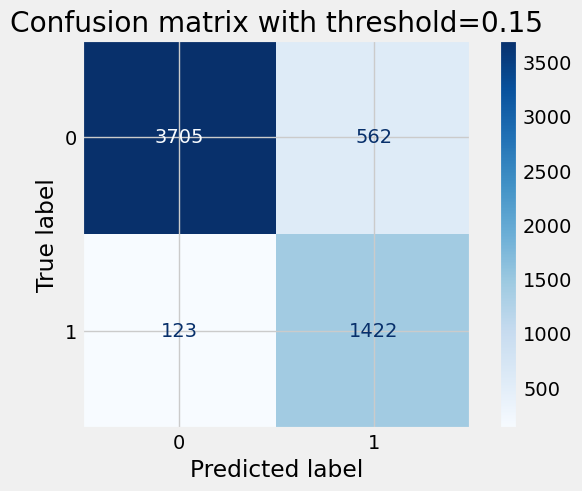

In [25]:
plot_conf_mat(final_xgb, # The classifier object
              testData_transformed, # The test data set aside for evaluation in train_test_split
              testLabels # Actual labels
             )

The cost will be equal to:

In [30]:
FP_Cost = (562 * 72) * (28539/5812)
FN_Cost = (123 * 347) * (28539/5812)

print("Total Cost = {}.".format(FP_Cost + FN_Cost))

Total Cost = 408271.70595320023.


In [27]:
FP_Cost = (253 * 72) * (28539/5812)
FN_Cost = (442 * 347) * (28539/5812)

print("Total Cost = {}.".format(FP_Cost + FN_Cost))

Total Cost = 842568.3086717136.


Let's compare this value with the previous two values:

In [28]:
Scenario_1_3 = 2312184.408293186 - 416796.0872333104
print("Savings compared to scenario 1: {}".format(Scenario_1_3))

Savings compared to scenario 1: 1895388.321059876


In [29]:
Scenario_2_3 = 1575046.3936682725 - 842568.3086717136
print("Savings compared to scenario 2: {}".format(Scenario_2_3))

Savings compared to scenario 2: 732478.084996559


### **Conclusion**  

This project successfully developed a **cost-sensitive predictive model** for hospital discharge outcomes, balancing performance optimization with financial impact. By implementing **feature engineering, hyperparameter tuning, and threshold adjustment**, we minimized the high cost of false negatives while maintaining acceptable false positives. The integration of **Bayesian optimization and cost-sensitive training** ensured that the model aligned with business objectives, maximizing its real-world value for **UVA Hospital**. Moving forward, further enhancements such as incorporating **real-time patient data and additional clinical variables** could improve model robustness and decision-making efficiency, leading to better patient care and resource allocation. 🚀